<a href="https://colab.research.google.com/github/rea-fernandes/flow_matching/blob/main/Mask_FlowMatching_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

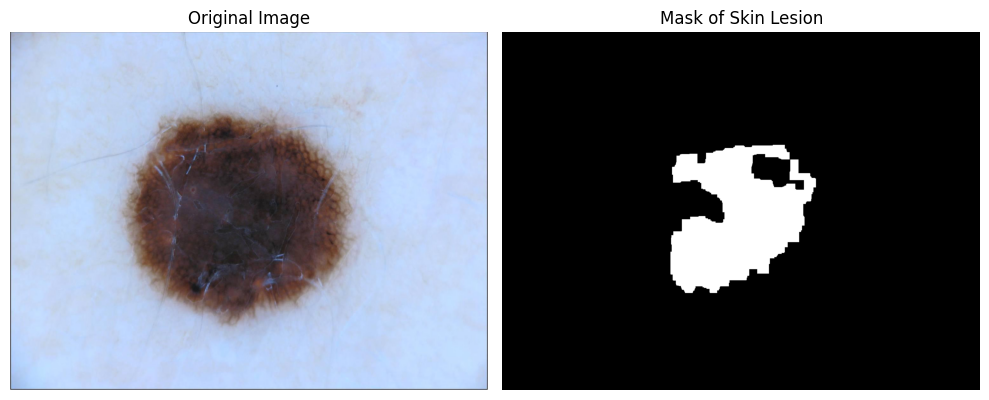

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('input_images/ISIC_0000039.jpg')  # Replace 'your_image.jpg' with the actual path
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply a threshold to create a binary mask
# You might need to adjust the threshold value based on your image
_, mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV) # Try a higher value and inverse



# Further refine the mask (optional)
# Apply morphological operations to remove noise and fill gaps
kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=5)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=5)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty mask with the same size as the original image
mask_image = np.zeros(gray.shape, dtype=np.uint8)

# Draw the largest contour (assuming the lesion is the largest connected component)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    cv2.drawContours(mask_image, [largest_contour], -1, 255, thickness=cv2.FILLED)

# Optional: Visualize the original image and the mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_image, cmap='gray')
plt.title('Mask of Skin Lesion')
plt.axis('off')

plt.tight_layout()
plt.show()

# The 'mask_image' variable now contains the binary mask of the skin lesion.
# White pixels (255) represent the lesion, and black pixels (0) represent the background.

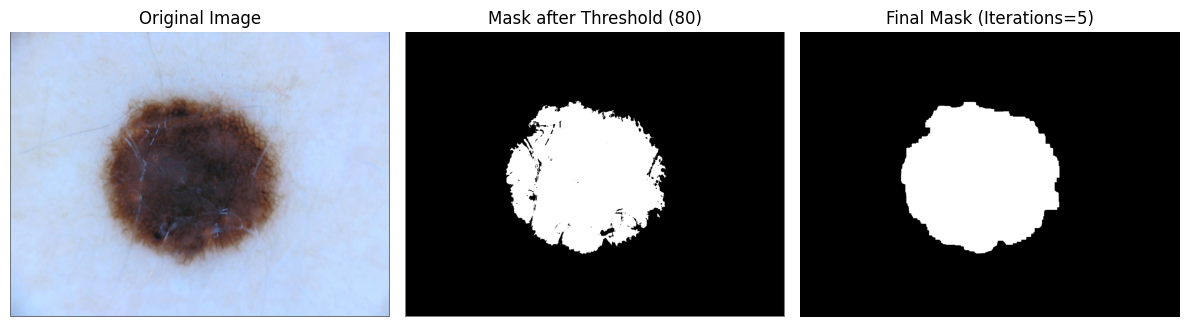

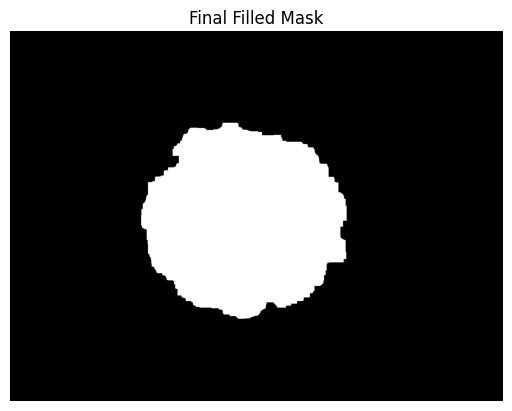

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('input_images/ISIC_0000039.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 1. Try a higher threshold and inverse binary
threshold_value = 80  # Start with a higher value, adjust as needed
_, mask = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY_INV)

# Visualize after thresholding
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title(f'Mask after Threshold ({threshold_value})')
plt.axis('off')

# 2. Reduce iterations of morphological operations
kernel = np.ones((5, 5), np.uint8)
iterations = 5  # Start with a smaller number
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=iterations)

# 3. Visualize the final mask
plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')
plt.title(f'Final Mask (Iterations={iterations})')
plt.axis('off')

plt.tight_layout()
plt.show()

# Continue with finding contours as in the original code
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_image = np.zeros(gray.shape, dtype=np.uint8)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    cv2.drawContours(mask_image, [largest_contour], -1, 255, thickness=cv2.FILLED)

# Optionally display the final filled mask
plt.figure()
plt.imshow(mask_image, cmap='gray')
plt.title('Final Filled Mask')
plt.axis('off')
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def create_lesion_mask(image_path, threshold_value=80, morph_iterations=5):
    """
    Creates a binary mask of a skin lesion from an image.

    Args:
        image_path (str): Path to the input image.
        threshold_value (int): Threshold value for binary conversion.
        morph_iterations (int): Number of iterations for morphological operations.

    Returns:
        numpy.ndarray or None: Binary mask of the lesion (white on black),
                                 or None if an error occurs.
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image at {image_path}")
            return None

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY_INV)

        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=morph_iterations)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=morph_iterations)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask_image = np.zeros(gray.shape, dtype=np.uint8)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            cv2.drawContours(mask_image, [largest_contour], -1, 255, thickness=cv2.FILLED)

        return mask_image

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def process_folder(input_folder, output_folder="masks"):
    """
    Processes all images in the input folder to create lesion masks
    and saves the masks in the output folder.

    Args:
        input_folder (str): Path to the folder containing the images.
        output_folder (str): Path to the folder where the masks will be saved.
                             Defaults to 'masks' in the current directory.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

    for image_file in image_files:
        image_path = os.path.join(input_folder, image_file)
        mask = create_lesion_mask(image_path)

        if mask is not None:
            mask_filename = f"{os.path.splitext(image_file)[0]}_mask.png"
            mask_output_path = os.path.join(output_folder, mask_filename)
            cv2.imwrite(mask_output_path, mask)
            print(f"Mask for {image_file} saved to {mask_output_path}")

if __name__ == "__main__":
    input_directory = "input_images"
    output_directory = "output_masks"

    # Create a dummy input folder and image for testing if it doesn't exist
    if not os.path.exists(input_directory):
        os.makedirs(input_directory)
        dummy_image = np.zeros((100, 100), dtype=np.uint8)
        cv2.imwrite(os.path.join(input_directory, "dummy.jpg"), dummy_image)
        print(f"Created dummy input folder '{input_directory}' with a dummy image.")

    process_folder(input_directory, output_directory)
    print(f"\nProcessing complete. Masks saved in '{output_directory}'.")

Mask for ISIC_0000295.jpg saved to output_masks/ISIC_0000295_mask.png
Mask for ISIC_0000535.jpg saved to output_masks/ISIC_0000535_mask.png
Mask for ISIC_0000523.jpg saved to output_masks/ISIC_0000523_mask.png
Mask for ISIC_0008029.jpg saved to output_masks/ISIC_0008029_mask.png
Mask for ISIC_0000299.jpg saved to output_masks/ISIC_0000299_mask.png
Mask for ISIC_0000079.jpg saved to output_masks/ISIC_0000079_mask.png
Mask for ISIC_0010081.jpg saved to output_masks/ISIC_0010081_mask.png
Mask for ISIC_0010479.jpg saved to output_masks/ISIC_0010479_mask.png
Mask for ISIC_0010374.jpg saved to output_masks/ISIC_0010374_mask.png
Mask for ISIC_0011144.jpg saved to output_masks/ISIC_0011144_mask.png
Mask for ISIC_0002287.jpg saved to output_masks/ISIC_0002287_mask.png
Mask for ISIC_0011145.jpg saved to output_masks/ISIC_0011145_mask.png
Mask for ISIC_0011169.jpg saved to output_masks/ISIC_0011169_mask.png
Mask for ISIC_0013595.jpg saved to output_masks/ISIC_0013595_mask.png
Mask for ISIC_000014

In [ ]:
!zip -r /content/mask.zip /content/output_masks/

  adding: content/output_masks/ (stored 0%)
  adding: content/output_masks/ISIC_0010596_mask.png (deflated 65%)
  adding: content/output_masks/ISIC_0010265_mask.png (deflated 75%)
  adding: content/output_masks/ISIC_0015190_mask.png (deflated 69%)
  adding: content/output_masks/ISIC_0000449_mask.png (deflated 83%)
  adding: content/output_masks/ISIC_0011339_mask.png (deflated 64%)
  adding: content/output_masks/ISIC_0000113_mask.png (deflated 80%)
  adding: content/output_masks/ISIC_0013672_mask.png (deflated 94%)
  adding: content/output_masks/ISIC_0013311_mask.png (deflated 85%)
  adding: content/output_masks/ISIC_0012976_mask.png (deflated 98%)
  adding: content/output_masks/ISIC_0014612_mask.png (deflated 84%)
  adding: content/output_masks/ISIC_0013438_mask.png (deflated 92%)
  adding: content/output_masks/ISIC_0012793_mask.png (deflated 77%)
  adding: content/output_masks/ISIC_0010066_mask.png (deflated 68%)
  adding: content/output_masks/ISIC_0014836_mask.png (deflated 65%)
  ad

In [ ]:
from google.colab import files
files.download("/content/mask.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>